In [264]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import table

In [265]:
#importing data from github repository 
BL = pd.read_csv('Data/BankLend.csv') 
consumption = pd.read_csv('Data/consumption 2.csv')
gdp_exp = pd.read_csv('Data/gdp.csv')
housing_starts = pd.read_csv('Data/HousingStarts.csv')
ex_rate = pd.read_csv('Data/CEER_MONTHLY_NOMINAL-sd-1990-01-01.csv') 
SP_tbills = pd.read_csv('Data/s&p, tbills.csv')
house_prices = pd.read_csv('Data/OECD Data.csv')

In [266]:
# BANK LENDING

# function for summing over rows of 3 to get quarterly data from the monthly data
def sum_quarter(group):
    return pd.Series({'ReferencePeriod': group['ReferencePeriod'].iloc[0],
                      'Total, funds advanced, residential mortgages, insured 7': group['Total, funds advanced, residential mortgages, insured 7'].sum(),
                      'Total, funds advanced, residential mortgages, uninsured 7': group['Total, funds advanced, residential mortgages, uninsured 7'].sum(),
                      'Total, funds advanced, variable rate mortgages': group['Total, funds advanced, variable rate mortgages'].sum(),
                      'Total, funds advanced for non-mortgage loans, consumer credit': group['Total, funds advanced for non-mortgage loans, consumer credit'].sum(),
                      'Total, funds advanced, business loans 8': group['Total, funds advanced, business loans 8'].sum()})

# applying the above function to groups of 3 rows to get quarterly data
BankLend = BL.groupby(BL.index // 3).apply(sum_quarter)
BankLend['ReferencePeriod'] = pd.to_datetime(BankLend['ReferencePeriod'])
BankLend['Quarters'] = BankLend['ReferencePeriod'].dt.to_period("Q").astype(str)

# summing up the different types of lending to get total Bank Lending
BankLend['BankLending'] = BankLend['Total, funds advanced, residential mortgages, insured 7'] + BankLend['Total, funds advanced, residential mortgages, uninsured 7'] +  BankLend['Total, funds advanced, variable rate mortgages'] + BankLend['Total, funds advanced for non-mortgage loans, consumer credit'] + BankLend['Total, funds advanced, business loans 8'] + BankLend['Total, funds advanced, business loans 8']

# creating a new dataframe with only the quarters and total bank lending
BankLend1 = BankLend[['Quarters','BankLending']]
BankLend1.head()

,Quarters,BankLending
0,2013Q1,382924.0
1,2013Q2,493784.0
2,2013Q3,483018.0
3,2013Q4,503383.0
4,2014Q1,420139.0


In [267]:
# GDP 

# creating a new dataframe with only the quarters and GDP
gdp = gdp_exp[['Quarters', 'Gross domestic product at market prices']]
gdp.head()

,Quarters,Gross domestic product at market prices
0,2000Q1,1514676
1,2000Q2,1532503
2,2000Q3,1548212
3,2000Q4,1551274
4,2001Q1,1560006


In [268]:
# EXCHANGE RATE

# keeping one column i.e. broad nominal exchange rate
filtered_ex_rate = ex_rate[['date','CEER_BROADNM']]
filtered_ceer = filtered_ex_rate.reset_index(drop=True)

# function for averaging over rows of 3 to get quarterly data from the monthly data
def average_quarter(group):
    return pd.Series({'date': group['date'].iloc[0],
                      'CEER_BROADNM': group['CEER_BROADNM'].mean()})

# applying the above function to groups of 3 rows to get quarterly data
ceer = filtered_ceer.groupby(filtered_ceer.index // 3).apply(average_quarter).reset_index(drop=True)

# converting date to datetime format
ceer['date'] = pd.to_datetime(ceer['date'])
ceer['Quarters'] = ceer['date'].dt.to_period("Q").astype(str)

# dropping the date column for the final dataframe
ceer = ceer.drop(['date'], axis=1)
ceer.head()

,CEER_BROADNM,Quarters
0,98.053333,1999Q1
1,101.366667,1999Q2
2,100.096667,1999Q3
3,100.486667,1999Q4
4,102.433333,2000Q1


In [269]:
# CONSUMPTION, HOUSE PRICES, HOUSING STARTS

# displaying the dataframes - already in quarterly format
print(consumption.head())
print(house_prices.head())
print(housing_starts.head())

  Quarters  Household final consumption expenditure
0   2000Q1                                   143884
1   2000Q2                                   145903
2   2000Q3                                   148957
3   2000Q4                                   150284
4   2001Q1                                   151594
  Quarters  House_Prices
0   2001Q1     40.844646
1   2001Q2     41.200980
2   2001Q3     41.875943
3   2001Q4     42.620664
4   2002Q1     43.340875
  Quarters  HousingStarts
0   2016Q1          38175
1   2016Q2          53286
2   2016Q3          54899
3   2016Q4          51555
4   2017Q1          42862


In [270]:
# FINANCIAL INDICATORS: S&P 500, T-BILLS

# function for averaging over rows of 3 to get quarterly data from the monthly data
def average_quarter(group):
    return pd.Series({'nummonth': group['nummonth'].iloc[0],
                      'sp': group['sp'].mean(), 't_bills': group['t_bills'].mean()})

# Group by sets of 3 rows and average using the custom function
fin_ind = SP_tbills.groupby(SP_tbills.index // 3).apply(average_quarter).reset_index(drop=True)

# cleaning dataframe and displaying
fin_ind.rename(columns={'nummonth': 'Quarters'}, inplace=True)
fin_ind.head()

,Quarters,sp,t_bills
0,2013Q1,36782.440000,0.953333
1,2013Q2,36089.766667,1.010000
2,2013Q3,37059.500000,0.990000
3,2013Q4,39750.513333,0.916667
4,2014Q1,41900.943333,0.876667


In [271]:
# merging all the dataframes to create the final dataframe using Quarters as the common column
merge1 = pd.merge(gdp, consumption, on = 'Quarters')
merge2 = pd.merge(merge1, BankLend1, on = 'Quarters')
merge3 = pd.merge(merge2, ceer, on = 'Quarters')
merge4 = pd.merge(merge3, house_prices, on = 'Quarters')
merge5 = pd.merge(merge4, housing_starts, on = 'Quarters')
final_merge = pd.merge(merge5, fin_ind, on = 'Quarters')

# renaming columns
final_merge.rename(columns={'Gross domestic product at market prices': 'GDP', 'Household final consumption expenditure': 'CON', 'BankLending': 'BL',
                         'CEER_BROADNM':'FX', 'House_Prices': 'HP', 'HousingStarts': 'HI', 'sp':'S&P', 't_bills':'IR'}, inplace=True)
final_merge.head()

,Quarters,GDP,CON,BL,FX,HP,HI,S&P,IR
0,2016Q1,2071732,285296,495823.0,111.046667,105.128205,38175,41244.963333,0.460000
1,2016Q2,2061412,286760,579799.0,117.166667,108.601056,53286,44654.566667,0.523333
2,2016Q3,2082805,289033,586583.0,116.170000,112.826169,54899,46931.136667,0.516667
3,2016Q4,2094490,292579,575781.0,115.810000,115.803167,51555,48612.290000,0.493333
4,2017Q1,2120843,296967,539456.0,117.380000,119.193062,42862,50214.126667,0.486667


In [272]:
# Reordering the columns in line with paper i.e. to align with the B matrix
final_df = final_merge[['Quarters', 'GDP', 'CON', 'HI', 'HP', 'S&P', 'BL', 'FX', 'IR']]
final_df.head()

,Quarters,GDP,CON,HI,HP,S&P,BL,FX,IR
0,2016Q1,2071732,285296,38175,105.128205,41244.963333,495823.0,111.046667,0.460000
1,2016Q2,2061412,286760,53286,108.601056,44654.566667,579799.0,117.166667,0.523333
2,2016Q3,2082805,289033,54899,112.826169,46931.136667,586583.0,116.170000,0.516667
3,2016Q4,2094490,292579,51555,115.803167,48612.290000,575781.0,115.810000,0.493333
4,2017Q1,2120843,296967,42862,119.193062,50214.126667,539456.0,117.380000,0.486667


In [273]:
# checking data types so that we can convert to float or int
final_df['Quarters'] = pd.to_datetime(final_df['Quarters'])
final_df.dtypes

# Convert to float
final_df['GDP'] = final_df['GDP'].astype(int)

# Convert to int
final_df['HI'] = final_df['HI'].astype(int)

final_df.head()

,Quarters,GDP,CON,HI,HP,S&P,BL,FX,IR
0,2016-01-01,2071732,285296,38175,105.128205,41244.963333,495823.0,111.046667,0.460000
1,2016-04-01,2061412,286760,53286,108.601056,44654.566667,579799.0,117.166667,0.523333
2,2016-07-01,2082805,289033,54899,112.826169,46931.136667,586583.0,116.170000,0.516667
3,2016-10-01,2094490,292579,51555,115.803167,48612.290000,575781.0,115.810000,0.493333
4,2017-01-01,2120843,296967,42862,119.193062,50214.126667,539456.0,117.380000,0.486667


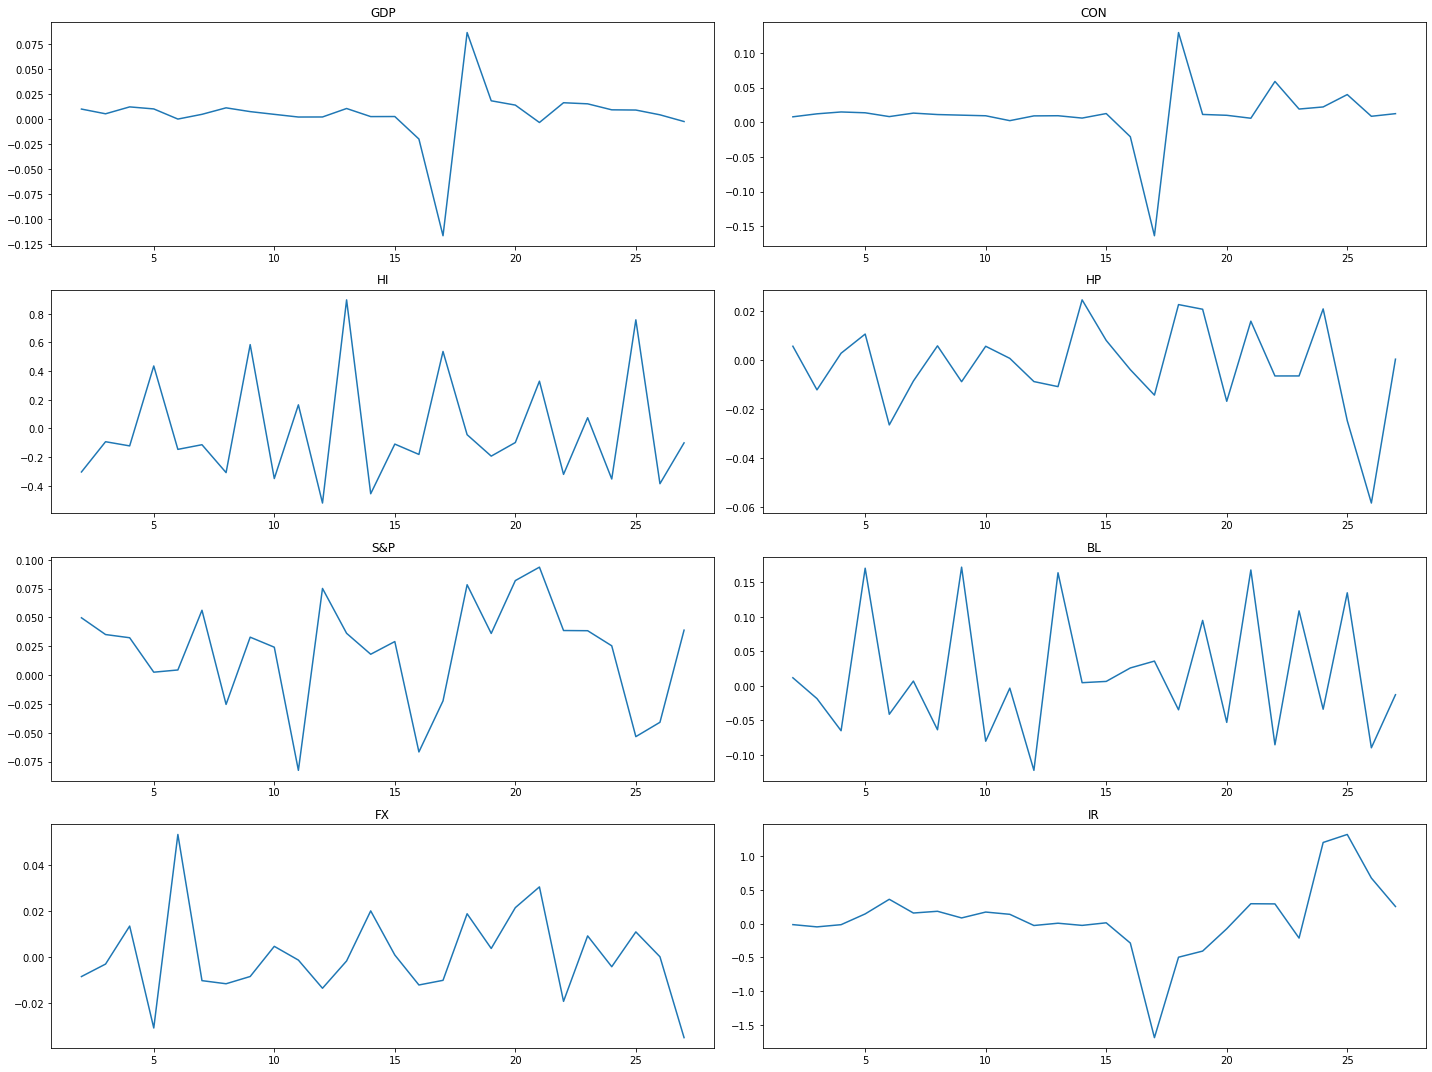

In [285]:
# Plotting time series graphs

# columns to be plotted
columns = ['GDP', 'CON', 'HI', 'HP', 'S&P', 'BL', 'FX', 'IR']

# Plotting the time series
fig, axs = plt.subplots(4, 2, figsize=(20, 15))
axs = axs.flatten()

# Plot each column
for i, col in enumerate(columns):
    axs[i].plot(final_df[col])
    axs[i].set_title(col)

# displaying plot
plt.tight_layout()
plt.show()

# saving output 
fig.savefig('Images/TS_regular.png')

In [275]:
# Log - difference
columns = ['GDP', 'CON', 'HI', 'HP', 'S&P', 'BL', 'FX', 'IR']

# Calculating log difference
for col in columns:
    final_df[col] = np.log(final_df[col]).diff()

# displaying dataframe
final_df = final_df.dropna()
final_df.head()

,Quarters,GDP,CON,HI,HP,S&P,BL,FX,IR
1,2016-04-01,-0.004994,0.005118,0.333493,0.032501,0.079428,0.156462,0.053647,0.128992
2,2016-07-01,0.010324,0.007895,0.029822,0.038167,0.049725,0.011633,-0.008543,-0.012821
3,2016-10-01,0.005595,0.012194,-0.062846,0.026044,0.035195,-0.018587,-0.003104,-0.046213
4,2017-01-01,0.012504,0.014886,-0.184664,0.028853,0.032420,-0.065166,0.013466,-0.013606
5,2017-04-01,0.010471,0.013695,0.250892,0.039482,0.002544,0.170521,-0.030974,0.146292


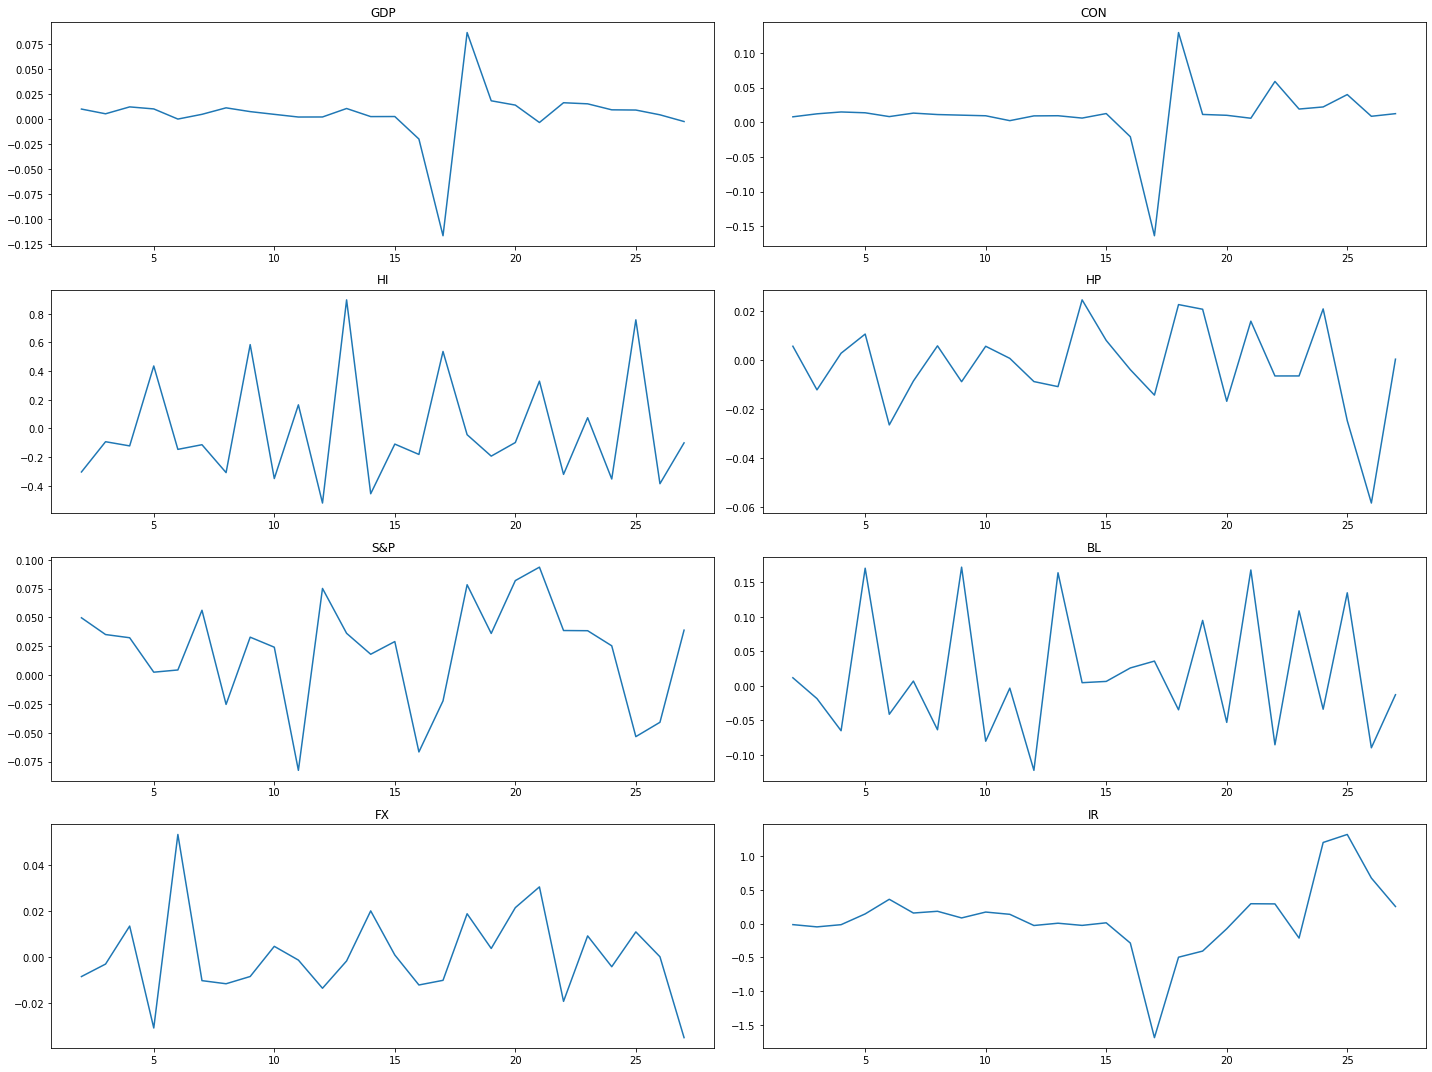

In [286]:
# Plotting time series graphs - log difference

# List of columns to plot after log difference
columns = ['GDP', 'CON', 'HI', 'HP', 'S&P', 'BL', 'FX', 'IR']

# Plotting
fig, axs = plt.subplots(4, 2, figsize=(20, 15))
axs = axs.flatten()

# Plot each column
for i, col in enumerate(columns):
    axs[i].plot(final_df[col])
    axs[i].set_title(col)

# Show the plot
plt.tight_layout()
plt.show()

# saving output 
fig.savefig('Images/TS_log.png')

In [277]:
# running ADF and KPSS tests

# defining a function to add significance markers
def significance_marker(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''

results_df = pd.DataFrame()

# running a for-loop for running the test on each column
for col in columns:
    adf_result = adfuller(final_df[col].dropna())
    kpss_result = kpss(final_df[col].dropna())
    new_row = pd.DataFrame({
        'Variable': [col], 
        'ADF p-value': [format(adf_result[1], '.3f') + significance_marker(adf_result[1])],
        'KPSS p-value': [format(kpss_result[1], '.3f') + significance_marker(kpss_result[1])],
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# displaying results as a markdown table
print(results_df.to_markdown(index=False))

# printing p values comment
print("\n***: p < 0.01, **: p < 0.05, *: p < 0.1")


| Variable   | ADF p-value   | KPSS p-value   |
|:-----------|:--------------|:---------------|
| GDP        | 0.000***      | 0.100          |
| CON        | 0.000***      | 0.100          |
| HI         | 0.620         | 0.042**        |
| HP         | 0.615         | 0.100          |
| S&P        | 0.002***      | 0.100          |
| BL         | 0.000***      | 0.100          |
| FX         | 0.000***      | 0.100          |
| IR         | 0.081*        | 0.100          |

***: p < 0.01, **: p < 0.05, *: p < 0.1


In [278]:
# Doubled differencing for HI and HP

# Columns to calculate another difference for
columns = ['HI', 'HP']

# for loop for another difference
for col in columns:
    final_df[col] = final_df[col].diff()

# Drop NA values
final_df = final_df.dropna()
final_df.head()

,Quarters,GDP,CON,HI,HP,S&P,BL,FX,IR
2,2016-07-01,0.010324,0.007895,-0.303671,0.005667,0.049725,0.011633,-0.008543,-0.012821
3,2016-10-01,0.005595,0.012194,-0.092667,-0.012124,0.035195,-0.018587,-0.003104,-0.046213
4,2017-01-01,0.012504,0.014886,-0.121818,0.002809,0.032420,-0.065166,0.013466,-0.013606
5,2017-04-01,0.010471,0.013695,0.435555,0.010630,0.002544,0.170521,-0.030974,0.146292
6,2017-07-01,0.000314,0.008200,-0.146047,-0.026415,0.004470,-0.041307,0.053410,0.363163


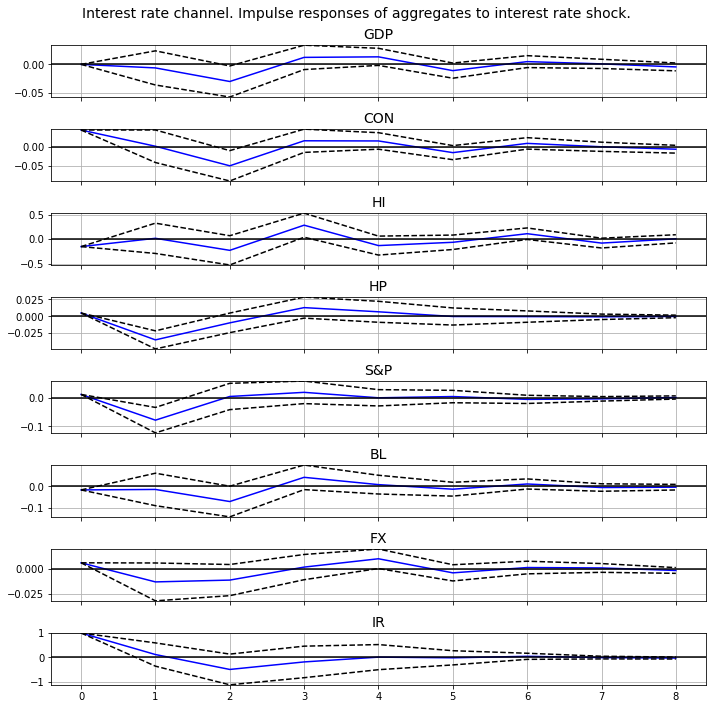

In [288]:
# Setting up the SVAR model

# List of variable names to be used in the model
var_names = ['GDP', 'CON', 'HI', 'HP', 'S&P', 'BL', 'FX', 'IR']

# Find the index of 't_bills' in this list
impulse_index = var_names.index('IR')

# Using this index for the impulse parameter
irf = result.irf(periods=8)

# Converting DataFrame to NumPy array
endog_data = final_df[['GDP', 'CON', 'HI', 'HP', 'S&P', 'BL', 'FX', 'IR']].to_numpy()

# Creating B-matrix as seen in the paper i.e. imposin short-term restrictions for SVAR 
B_matrix = np.array([
    [1, 'E', 'E', 0, 0, 0, 0, 0],
    [0, 1, 0, 'E', 'E', 'E', 0, 'E'],
    [0, 0, 1, 'E', 0,'E', 0, 'E'],
    [0, 0, 0, 1, 'E', 'E', 0, 'E'],
    [0, 0, 0, 0, 1, 'E', 'E', 'E'],
    [0, 0, 0, 0, 0, 1, 'E', 'E'],
    [0, 0, 0, 0, 0, 0, 1, 'E'],
    [0, 0, 0, 0, 0, 0, 0, 1],
])

# Define SVAR Model
svar_model = SVAR(endog=endog_data, svar_type='B', A=None, B=B_matrix, dates=final_df['Quarters'])
result = svar_model.fit()

# Plotting
fig = irf.plot(impulse=impulse_index, plot_stderr=True, subplot_params={'figsize': (10, 20)})

# for loop over the axes to add titles and grid
for i, ax in enumerate(fig.axes):
    ax.set_title(f'{var_names[i]}', fontsize=14)
    ax.grid(True)
    ax.autoscale(enable=True, axis='y', tight=True)  # Automatically adjust y-axis limits

fig.suptitle('Interest rate channel. Impulse responses of aggregates to interest rate shock.', fontsize=14)

# displaying the plot
plt.tight_layout()
plt.show()

# saving output 
fig.savefig('Images/IR_channel.png')

In [280]:
# Getting the impulse responses for all periods
irfs = irf.irfs

# converting the array into a DataFrame
df = pd.DataFrame(irfs[:, impulse_index, :], columns=var_names)

# Setting the index to periods
df.index.name = 'Period'

# Displaying with a title
print("Interest rate channel. Impulse responses of aggregates to interest rate shock.")
display(df)

Interest rate channel. Impulse responses of aggregates to interest rate shock.


,GDP,CON,HI,HP,S&P,BL,FX,IR
Period,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,20.242659,-17.716420,0.366914,1.595853,4.934460,-0.671629,1.298176,0.869537
2,27.593115,-18.212173,0.042074,-4.081873,2.367286,-0.404772,-1.089476,0.314083
3,7.606636,-3.551152,0.185669,-2.012521,0.425521,-0.624229,-1.125085,0.002511
4,-0.885387,-0.111712,0.055822,0.590669,0.219118,-0.448335,-0.515980,0.014998
5,0.347252,-0.124200,-0.106664,-0.889835,-0.401011,0.492403,0.316317,-0.010769
6,-0.838386,0.860764,0.056491,0.558746,0.026274,-0.192509,-0.228498,0.010715
7,0.366589,-0.715104,0.004500,0.110848,0.241678,-0.062099,0.175112,0.019775
8,0.833631,-0.321583,-0.031592,-0.436835,-0.138465,0.159279,-0.037628,-0.008677


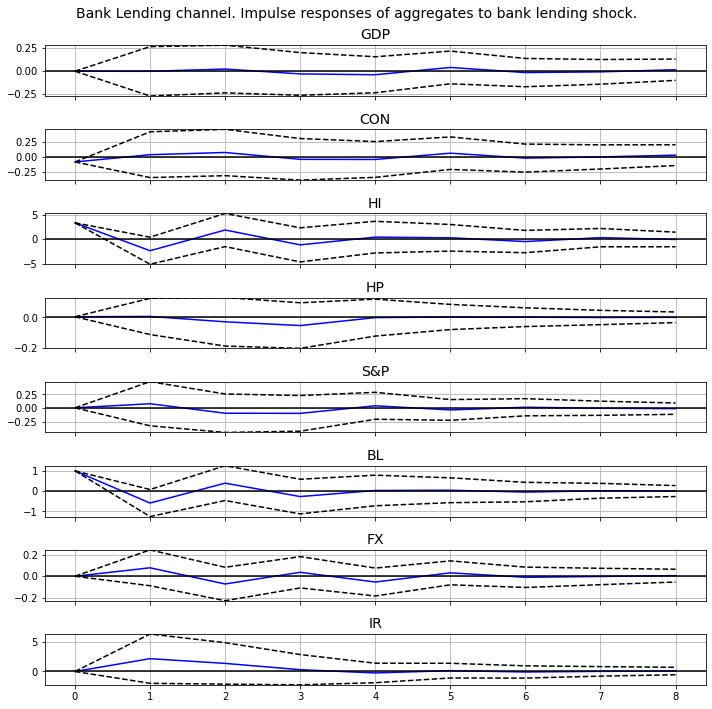

In [289]:
# List of variable names to be used in the model
var_names = ['GDP', 'CON', 'HI', 'HP', 'S&P', 'BL', 'FX', 'IR']

# Find the index of 't_bills' in this list
impulse_index = var_names.index('BL')

# Using this index for the impulse parameter
irf = result.irf(periods=8)

# Plotting
fig = irf.plot(impulse=impulse_index, plot_stderr=True, subplot_params={'figsize': (10, 20)})

# for loop over the axes to add titles and grid
for i, ax in enumerate(fig.axes):
    ax.set_title(f'{var_names[i]}', fontsize=14)
    ax.grid(True)
    ax.autoscale(enable=True, axis='y', tight=True)  # Automatically adjust y-axis limits

fig.suptitle('Bank Lending channel. Impulse responses of aggregates to bank lending shock.', fontsize=14)

# displaying the plot
plt.tight_layout()
plt.show()

# saving output 
fig.savefig('Images/BL_channel.png')

In [282]:
# Getting the impulse responses for all periods
irfs = irf.irfs

# converting the array into a DataFrame
df = pd.DataFrame(irfs[:, impulse_index, :], columns=var_names)

# Setting the index to periods
df.index.name = 'Period'

# Displaying with a title
print("Bank Lending channel. Impulse responses of aggregates to interest rate shock.")
display(df)

Bank Lending channel. Impulse responses of aggregates to interest rate shock.


,GDP,CON,HI,HP,S&P,BL,FX,IR
Period,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1,1.724040,-1.176475,0.095013,1.217467,0.542581,-1.015136,-0.614567,0.026473
2,0.568585,-0.479141,-0.081215,-1.512833,-0.232048,0.628580,0.661830,-0.043942
3,-1.140858,1.235670,0.037367,0.765418,-0.175577,-0.280145,-0.668561,-0.009213
4,-0.595922,-0.054817,-0.002196,-0.009285,0.140349,0.035177,0.456090,0.006561
5,0.531969,-0.178843,-0.027484,-0.173569,-0.122814,0.122107,-0.152526,-0.003534
6,-0.302003,0.251203,0.025356,0.149580,0.050614,-0.106884,0.019148,0.000725
7,0.091134,-0.200168,-0.007221,-0.012730,0.033013,0.025421,0.020036,0.002673
8,0.129271,0.018381,-0.006976,-0.096543,-0.054084,0.031283,-0.011315,-0.003527


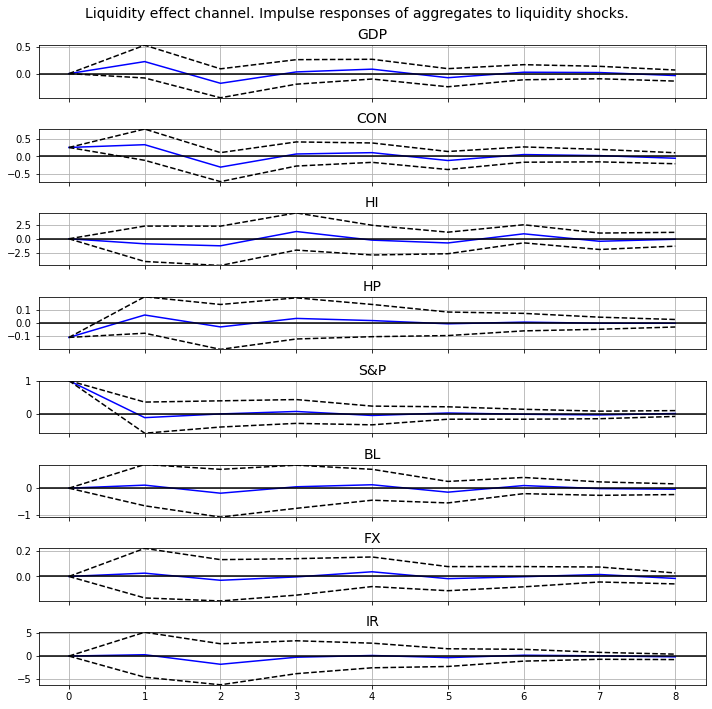

In [290]:
# List of variable names to be used in the model
var_names = ['GDP', 'CON', 'HI', 'HP', 'S&P', 'BL', 'FX', 'IR']

# Find the index of 't_bills' in this list
impulse_index = var_names.index('S&P')

# Using this index for the impulse parameter
irf = result.irf(periods=8)

# Plotting
fig = irf.plot(impulse=impulse_index, plot_stderr=True, subplot_params={'figsize': (10, 20)})

# for loop over the axes to add titles and grid
for i, ax in enumerate(fig.axes):
    ax.set_title(f'{var_names[i]}', fontsize=14)
    ax.grid(True)
    ax.autoscale(enable=True, axis='y', tight=True)  # Automatically adjust y-axis limits

fig.suptitle('Liquidity effect channel. Impulse responses of aggregates to liquidity shocks.', fontsize=14)

# displaying the plot
plt.tight_layout()
plt.show()

# saving output 
fig.savefig('Images/LE_channel.png')

In [284]:
# Getting the impulse responses for all periods
irfs = irf.irfs

# converting the array into a DataFrame
df = pd.DataFrame(irfs[:, impulse_index, :], columns=var_names)

# Setting the index to periods
df.index.name = 'Period'

# Displaying with a title
print("Liquidity Effect channel. Impulse responses of aggregates to interest rate shock.")
display(df)


Liquidity Effect channel. Impulse responses of aggregates to interest rate shock.


,GDP,CON,HI,HP,S&P,BL,FX,IR
Period,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,1.313327,-0.768119,-0.008369,-0.819519,0.002040,0.043405,0.514551,-0.043331
2,-1.114517,0.993327,0.005159,0.197023,-0.220417,-0.016978,-0.436294,-0.032860
3,-1.060492,0.558717,-0.005289,0.170465,-0.040497,-0.025475,0.189245,-0.006464
4,-0.130468,0.101873,-0.017639,-0.066292,-0.070244,0.113006,0.031622,-0.002596
5,-0.074180,0.086521,0.011245,0.118425,0.027029,-0.061129,-0.024887,0.002139
6,0.080130,-0.121282,-0.002172,-0.034978,0.025771,0.014169,0.038258,0.000917
7,0.071095,0.003539,-0.003111,-0.035567,-0.026561,0.010816,-0.026450,-0.001869
8,-0.101552,0.061489,0.004348,0.036758,0.009231,-0.016714,0.003604,0.000102
